Multi-photon transitision to excited bands
=
During an optical lattice is being shaken, multi-phon transition to excited bands happens if the following condition is met;
\begin{equation}
\begin{array}{c}
{\rm{Min}} [ E_{higher}(\boldsymbol{K}) - E_{ground}(\boldsymbol{K})] \le n \hbar \Omega \le  {\rm{Max}} [ E_{higher}(\boldsymbol{K}) - E_{ground}(\boldsymbol{K})] \\
1 \le n \in \mathbb{Z} \\
\end{array}
\end{equation}
where $ E_{higher}(\boldsymbol{K}) - E_{ground}(\boldsymbol{K})$ is the band gap between the ground and certain excited bands, and $\Omega [rad \cdot Hz]$ is the driving frequency of the shaken lattice.

In this numerical calculation, we take into consideration the band gap between 1st and 2nd bands, which has a dominant effect on the excitation.

As far as QMBD lab is concerned, we define the optical triangular lattice potential as follows
\begin{equation}
V(\boldsymbol{r}) = -V_1 {\rm{cos}}(\boldsymbol{b_2} \cdot \boldsymbol{r} - \phi_{23}) - V_2 {\rm{cos}}((\boldsymbol{b_1}-\boldsymbol{b_2})\cdot \boldsymbol{r} + \phi_{13}) - V_3 {\rm{cos}}(\boldsymbol{b_1}\cdot \boldsymbol{r}) + {\rm{offset}}
\end{equation}

In Sengstock group, the optical potential is defined as
\begin{equation}
V(\boldsymbol{r}) = -\frac{V}{2} [{\rm{cos}}(\boldsymbol{b_2} \cdot \boldsymbol{r}) - {\rm{cos}}((\boldsymbol{b_1}-\boldsymbol{b_2})\cdot \boldsymbol{r} + \phi_{13}) - {\rm{cos}}(\boldsymbol{b_1}\cdot \boldsymbol{r})] + {\rm{offset}}
\end{equation}

In [8]:
# -*- coding: utf-8 -*-
import numpy as np
lam = 1 # Normalized wavelength
d = lam/2 # lattice constant

lambda_L = 1064*10**(-9) #wave lenght of triangular lattice beam [m] 
h_bar = 1.054571596*10**(-34) #Converted Plank const
mrb = 87*1.66053873*10**(-27) #Single atom mass of 87Yb
er = h_bar**2/(2*mrb)*(2*np.pi/lambda_L)**2 #Recoil energy of 532nm lattice
n = 8 # include (2n+1)^2 plane waves in calculation <=> calculate over (2n+1)^2 bands

#Quasimomentum list
q_list = [(0,0), (1/2,0), (2/3,1/3), (1/2,1/2)] #Gamma =(0,0), M = (1/2,0), K = (2/3,1/3), X = (1/2,1/2)

#Potential list
vmin = 1
vmax = 6
v_list = np.linspace(vmin,vmax,50) #Potential = 2ER - 6ER
gap_min = np.zeros(len(v_list))
gap_max = np.zeros(len(v_list))

Band calculation
--

In [9]:
Nsite=2*n+1
l_list = [(x, y) for x in np.linspace(-n, n, Nsite, dtype=np.int) for y in np.linspace(-n, n, Nsite, dtype=np.int)]
E = np.zeros([len(q_list), Nsite**2])
C = np.zeros([Nsite**2, len(q_list), Nsite**2])
H_tmp = np.zeros([Nsite**2, Nsite**2])

l_list_1 = np.array(l_list)[:, 0]
l_list_2 = np.array(l_list)[:, 1]
l2, l1 = np.meshgrid(l_list_1, l_list_1)
m2, m1 = np.meshgrid(l_list_2, l_list_2)

l_diffs_1 = l1 - l2
l_diffs_2 = m1 - m2
l_diffs = l_diffs_1 * l_diffs_2
condition_1 = (np.abs(l_diffs_1) == 1) * (m1 == m2)
condition_2 = (l1 == l2) * (np.abs(l_diffs_2) == 1)
condition_3 = (l_diffs == 1)

for i_v, v in enumerate(v_list):
    H_tmp = np.zeros([Nsite**2, Nsite**2])
#     H_tmp[condition_1 == 1] = 0.1
    H_tmp[condition_1 == 1] = -v/2
    H_tmp[condition_2 == 1] += -v/2
    H_tmp[condition_3 == 1] += -v/2
    for i_q, q in enumerate(q_list):
        H = np.copy(H_tmp)
        K = 3 * ((q[0] - l1)**2 + (q[1] - m1)**2 - (q[0] - l2) * (q[1] - m2))
        H += ((l1 == l2) * (m1 == m2)) * K
        E0, P = np.linalg.eig(H)
        rearrangedEvalsVecs = sorted(zip(E0, P.T), key=lambda x: x[0].real, reverse=False)
        E[i_q, :], tmp = map(list, zip(*rearrangedEvalsVecs))
        #C[:, i_q, :] = np.array(tmp)
    gap_min[i_v] = np.min(E[:,1]-E[:,0])
    gap_max[i_v] = np.max(E[:,1]-E[:,0])

gap_min *= er/(2*np.pi*h_bar)*10**(-3) # unit conversion: [E_R] => [kHz]
gap_max *= er/(2*np.pi*h_bar)*10**(-3) 

<ipython-input-9-db31069149dd>:31: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i_q, :], tmp = map(list, zip(*rearrangedEvalsVecs))


Plot figure
--

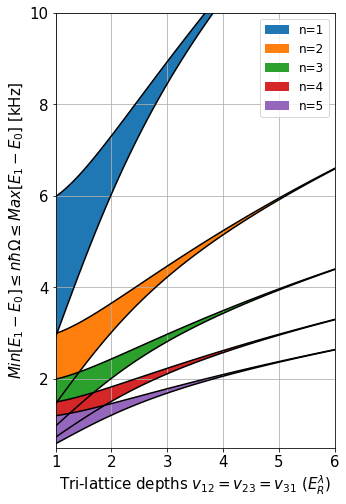

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[5,8])
for n in range(1,6):
    ax.plot(v_list,gap_min/n,v_list,gap_max/n,color = "black")
    ax.fill_between(v_list,gap_min/n,gap_max/n,label="n="+str(n))
ax.set_xlabel(r"Tri-lattice depths $v_{12} = v_{23} = v_{31}$ $(E_R^{\lambda})$", fontsize=15)
# ax.set_xlabel(r"Lattice depths $v_{12}=v_{23} = v_{31}$ $[E_R]$", fontsize=15)
ax.set_ylabel(r"$Min[E_1-E_0] \leq n \hbar \Omega \leq Max[E_1-E_0]$ [kHz]", fontsize=15)
ax.set_xlim([vmin,vmax])
ax.set_ylim([0.5,10])
ax.tick_params(axis='x',labelsize=15)
ax.tick_params(axis='y',labelsize=15)
ax.legend(fontsize=12)
ax.grid()